# Exercice 1

## Breast cancer

In cancer detection, we want to minimize incorrect negative predictions (i.e. the sick patient is classified as negative) because this diagnosis could lead to serious health problems. Therefore, the most important metric in the application of cancer detection is the recall which objective is to limit the number of false negatives.

### Load data

In [55]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [56]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

**Target**  
'0' => malignant/sick  
'1' => benign/safe

### Preprocessing

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(df_cancer.drop('target', axis=1), df_cancer['target'], test_size=0.3, random_state=42)

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Training

In [59]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

grid_nb = {}

grid_dt = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

grid_rf = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

grid_gb = {
    'max_depth': range(1, X_train_sc.shape[1] + 1)
}

models_name = [
    "Naive Bayes", 
    "Decision Tree", 
    "Random Forest", 
    "Gradient Boosting",
    ]

grids = [
    grid_nb, 
    grid_dt, 
    grid_rf, 
    grid_gb,
]

models = [
    BernoulliNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
]

cv = 10

In [60]:
from sklearn.model_selection import GridSearchCV
from utils import grid_search_by_hand, model_evaluation_clf
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results_gs = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
results_hand = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models_gs_sc = {}
models_gs = {}

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    gs_sc = GridSearchCV(model, param_grid=grid, scoring='recall', cv=cv, n_jobs=-1)
    gs = GridSearchCV(model, param_grid=grid, scoring='recall', cv=cv, n_jobs=-1)
    hand_sc = grid_search_by_hand(deepcopy(model), grid, X_train_sc, y_train, cv, 'recall')
    hand = grid_search_by_hand(deepcopy(model), grid, X_train, y_train, cv, 'recall')

    gs_sc.fit(X_train_sc, y_train)
    gs.fit(X_train, y_train)
    models_gs[model_name] = gs
    models_gs_sc[model_name + ' (sc)'] = gs_sc
    hand_sc['best_model'].fit(X_train_sc, y_train)
    hand['best_model'].fit(X_train, y_train)

    eval_gs_sc = model_evaluation_clf(gs_sc, X_test_sc, y_test)
    eval_gs = model_evaluation_clf(gs, X_test, y_test)
    eval_hand_sc = model_evaluation_clf(hand_sc['best_model'], X_test_sc, y_test)
    eval_hand = model_evaluation_clf(hand['best_model'], X_test, y_test)

    results_gs.loc[2*i] = [model_name, eval_gs['accuracy'], eval_gs['precision'], eval_gs['recall'], eval_gs['f1'], eval_gs['roc_auc']]
    results_gs.loc[2*i+1] = [model_name + ' (sc)', eval_gs_sc['accuracy'], eval_gs_sc['precision'], eval_gs_sc['recall'], eval_gs_sc['f1'], eval_gs_sc['roc_auc']]
    results_hand.loc[2*i] = [model_name, eval_hand['accuracy'], eval_hand['precision'], eval_hand['recall'], eval_hand['f1'], eval_hand['roc_auc']]
    results_hand.loc[2*i+1] = [model_name + ' (sc)', eval_hand_sc['accuracy'], eval_hand_sc['precision'], eval_hand_sc['recall'], eval_hand_sc['f1'], eval_hand_sc['roc_auc']]

results_gs = results_gs.sort_values(by='Recall', ascending=False)
results_hand = results_hand.sort_values(by='Recall', ascending=False)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:16<00:00,  4.55s/it]


## Results

### With GridSearch

In [61]:
print(results_gs.to_string(index=False))

                 Model  Accuracy  Precision  Recall  f1-score   AUC
           Naive Bayes     0.632      0.632   1.000     0.774 0.500
         Random Forest     0.971      0.964   0.991     0.977 0.964
    Random Forest (sc)     0.971      0.964   0.991     0.977 0.964
         Decision Tree     0.965      0.964   0.981     0.972 0.959
    Decision Tree (sc)     0.965      0.964   0.981     0.972 0.959
     Gradient Boosting     0.965      0.964   0.981     0.972 0.959
Gradient Boosting (sc)     0.965      0.964   0.981     0.972 0.959
      Naive Bayes (sc)     0.965      0.972   0.972     0.972 0.962


### By hand

In [62]:
print(results_hand.to_string(index=False))

                 Model  Accuracy  Precision  Recall  f1-score   AUC
           Naive Bayes     0.632      0.632   1.000     0.774 0.500
         Random Forest     0.971      0.964   0.991     0.977 0.964
    Random Forest (sc)     0.971      0.964   0.991     0.977 0.964
         Decision Tree     0.965      0.964   0.981     0.972 0.959
    Decision Tree (sc)     0.965      0.964   0.981     0.972 0.959
     Gradient Boosting     0.965      0.964   0.981     0.972 0.959
Gradient Boosting (sc)     0.965      0.964   0.981     0.972 0.959
      Naive Bayes (sc)     0.965      0.972   0.972     0.972 0.962


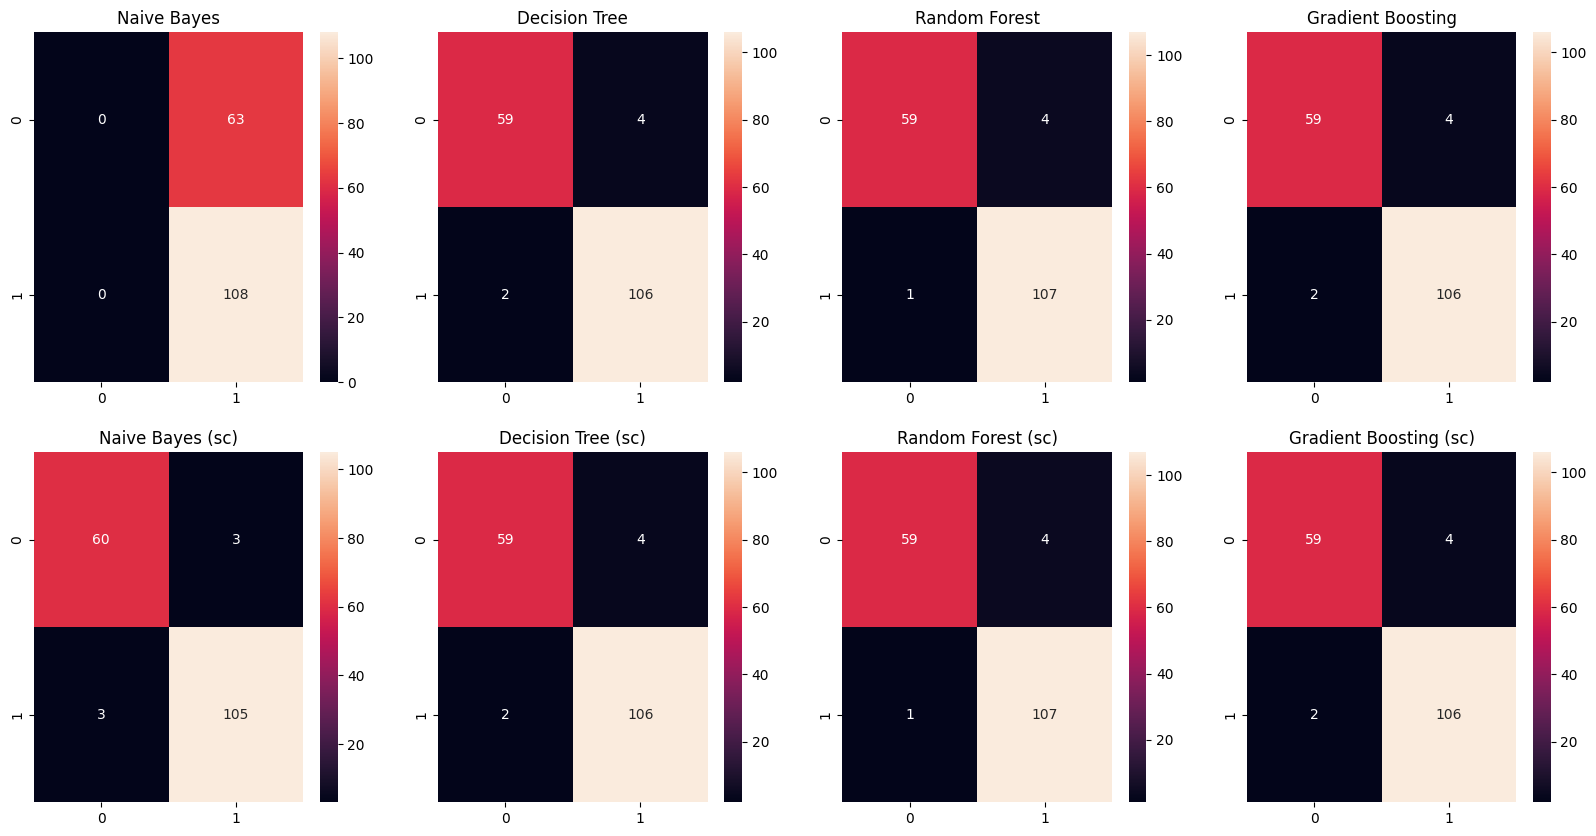

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, model_name in enumerate(models_gs.keys()):
    model = models_gs[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[0, i])
    axs[0, i].set_title(model_name)

for i, model_name in enumerate(models_gs_sc.keys()):
    model = models_gs_sc[model_name]
    y_pred = model.predict(X_test_sc)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[1, i])
    axs[1, i].set_title(model_name)

plt.show()

## Boston Housing

### Load data

In [64]:
import mglearn
X, y = mglearn.datasets.load_extended_boston()

### Preprocessing

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Training

In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

grid_dt = {
    'max_depth': range(1, X_train.shape[1] + 1, 5)
}

grid_rf = {
    'max_depth': range(1, X_train.shape[1] + 1, 5)
}

grid_gb = {
    'max_depth': range(1, X_train.shape[1] + 1, 5)
}

models_name = [
    "Decision Tree", 
    "Random Forest", 
    "Gradient Boosting"
]

grids = [
    grid_dt, 
    grid_rf, 
    grid_gb
]

models = [
    # Bayesian Regression TODO,
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
]

cv = 5

In [69]:
from sklearn.model_selection import GridSearchCV
from utils import grid_search_by_hand, model_evaluation_lr
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results_gs = pd.DataFrame(columns=["Model", "MAPE", "RMSE", "r2"])
results_hand = pd.DataFrame(columns=["Model", "MAPE", "RMSE", "r2"])
models_gs_sc = {}
models_gs = {}

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    gs_sc = GridSearchCV(model, param_grid=grid, scoring='r2', cv=cv, n_jobs=-1)
    gs = GridSearchCV(model, param_grid=grid, scoring='r2', cv=cv, n_jobs=-1)
    hand_sc = grid_search_by_hand(deepcopy(model), grid, X_train_sc, y_train, cv, 'r2')
    hand = grid_search_by_hand(deepcopy(model), grid, X_train, y_train, cv, 'r2')

    gs_sc.fit(X_train_sc, y_train)
    gs.fit(X_train, y_train)
    models_gs[model_name] = gs
    models_gs_sc[model_name + ' (sc)'] = gs_sc
    hand_sc['best_model'].fit(X_train_sc, y_train)
    hand['best_model'].fit(X_train, y_train)

    eval_gs_sc = model_evaluation_lr(gs_sc, X_test_sc, y_test)
    eval_gs = model_evaluation_lr(gs, X_test, y_test)
    eval_hand_sc = model_evaluation_lr(hand_sc['best_model'], X_test_sc, y_test)
    eval_hand = model_evaluation_lr(hand['best_model'], X_test, y_test)

    results_gs.loc[2*i] = [model_name, eval_gs['mape'], eval_gs['rmse'], eval_gs['r2']]
    results_gs.loc[2*i+1] = [model_name + ' (sc)', eval_gs_sc['mape'], eval_gs_sc['rmse'], eval_gs_sc['r2']]
    results_hand.loc[2*i] = [model_name, eval_hand['mape'], eval_hand['rmse'], eval_hand['r2']]
    results_hand.loc[2*i+1] = [model_name + ' (sc)', eval_hand_sc['mape'], eval_hand_sc['rmse'], eval_hand_sc['r2']]

results_gs = results_gs.sort_values(by='r2', ascending=False)
results_hand = results_hand.sort_values(by='r2', ascending=False)

100%|██████████| 21/21 [02:22<00:00,  6.77s/it]


## Results

### With GridSearch

In [70]:
print(results_gs.to_string(index=False))

                 Model     MAPE  RMSE    r2
    Random Forest (sc) 0.103374 3.150 0.867
         Random Forest 0.103314 3.177 0.865
    Decision Tree (sc) 0.136916 3.723 0.814
     Gradient Boosting 0.129228 3.754 0.811
Gradient Boosting (sc) 0.129228 3.754 0.811
         Decision Tree 0.146741 4.167 0.767


### By hand

In [71]:
print(results_hand.to_string(index=False))

                 Model     MAPE  RMSE    r2
    Random Forest (sc) 0.103374 3.150 0.867
         Random Forest 0.103314 3.177 0.865
    Decision Tree (sc) 0.136916 3.723 0.814
     Gradient Boosting 0.129228 3.754 0.811
Gradient Boosting (sc) 0.129228 3.754 0.811
         Decision Tree 0.146741 4.167 0.767


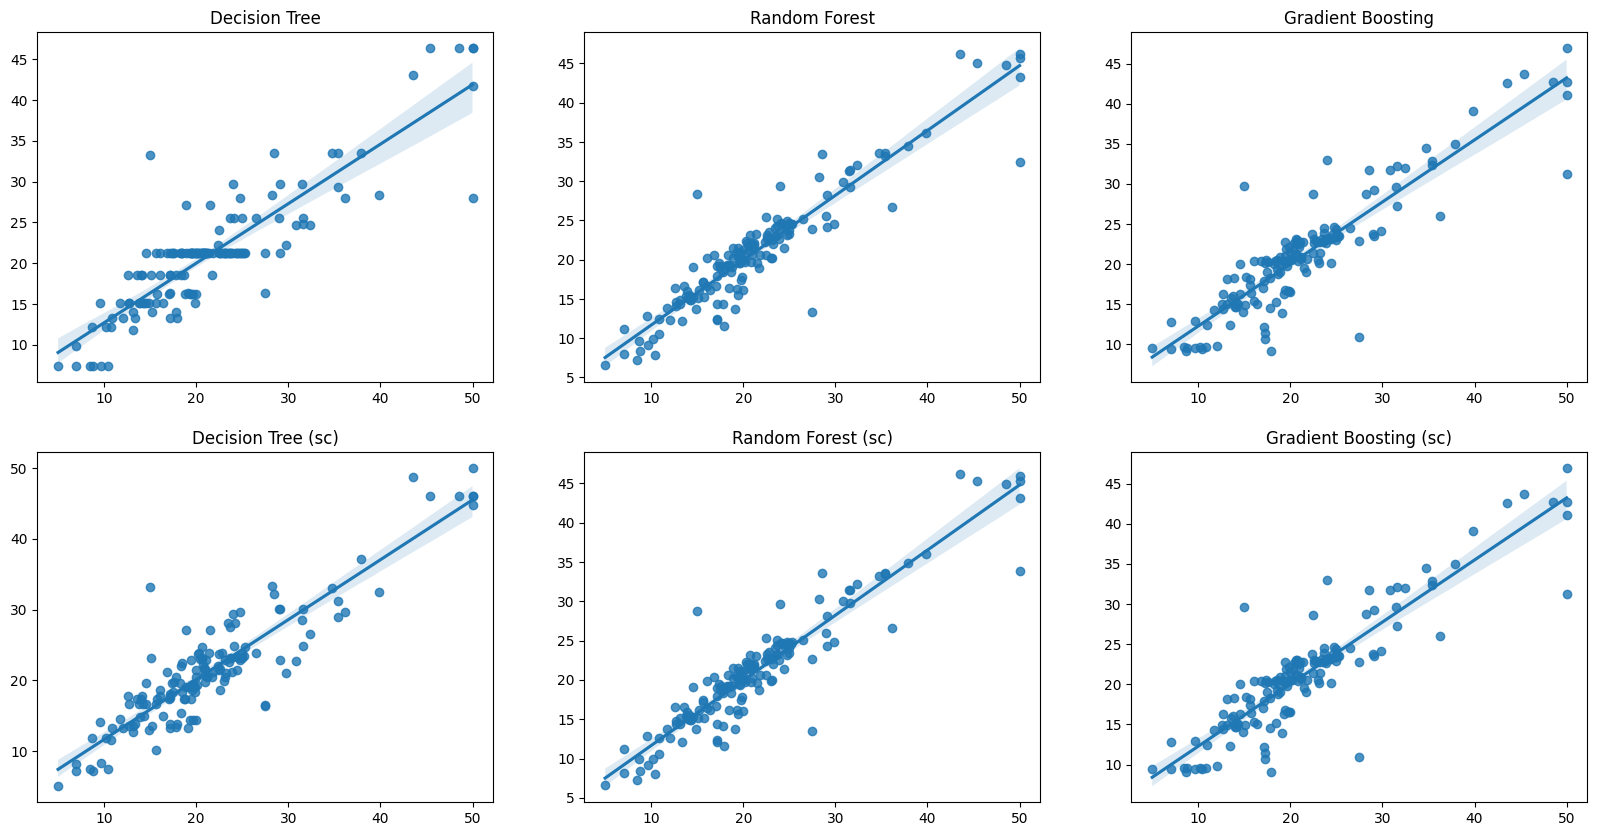

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, model_name in enumerate(models_gs.keys()):
    model = models_gs[model_name]
    y_pred = model.predict(X_test)
    sns.regplot(x=y_test, y=y_pred, ax=axs[0, i])
    axs[0, i].set_title(model_name)

for i, model_name in enumerate(models_gs_sc.keys()):
    model = models_gs_sc[model_name]
    y_pred = model.predict(X_test_sc)
    sns.regplot(x=y_test, y=y_pred, ax=axs[1, i])
    axs[1, i].set_title(model_name)

plt.show()